In [1]:
%matplotlib inline

# Using YouTube API to Analyze Mr. Beast's Videos' Metrics

This is a short project that utlizes YouTube's publicly available and well-documented API to access information on YouTube such as, but not limited to: video statistics, channel statistics, user information, playlist information, etc.

In this project the goal is to analyze the last 50 videos that Mr. Beast uploaded and see if we can draw any insights from our data. (We analyze the last 50 videos because that is the video limit amount that I can access using the methods utilized.)

# Imports

In [2]:
from googleapiclient.discovery import build
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# API Key

The api key is your credential provided from google to access the YouTube API and YouTube information. Do not share your key with anyone as this will enable anyone to access YouTube data on your behalf.

In [3]:
#your api key goes here BUT DO NOT SHARE IT WITH ANYONE
api_key = "" 

#accessing YouTube v3 API
youtube = build(serviceName="youtube", version="v3", developerKey=api_key)

# Getting Uploads ID
<br>

We need to get the id for Mr.Beast's channel uploads. We can do this if we know the channel's unique ID or their username. Unfortunately, the channel ID isn't very straightforward to get anymore. There is a way to get the upload ID from the channel's username, but the channel username isn't always the same as the channel's public name (ex. "Mr. Beast" may be the public name of the channel, but not the username of the channel that YouTube's API will recognize. Confusing? Yes, I agree.)

I used this website to get the channel ID of Mr. Beast (https://commentpicker.com/youtube-channel-id.php). Once you have the ID you can just run these next steps and look at the output to see if you have the correct channel.

In [4]:
#This is the usual syntax for accessing the YouTube API where you have to use the .execute() method
request = youtube.channels().list(part = ["contentDetails"],
                                  id = "UCX6OQ3DkcsbYNE6H8uQQuVA") #Mr Beast channel ID

response = request.execute()
print(response)

{'kind': 'youtube#channelListResponse', 'etag': 'mky5yfatRnp-E8N9-BwXGY8W8Dk', 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5}, 'items': [{'kind': 'youtube#channel', 'etag': '-f8h6RTCebSZttPcDz3dTkMV5yo', 'id': 'UCX6OQ3DkcsbYNE6H8uQQuVA', 'contentDetails': {'relatedPlaylists': {'likes': '', 'uploads': 'UUX6OQ3DkcsbYNE6H8uQQuVA'}}}]}


Here we can see at the end of the json file the 'uploads' key with the corresponding playlistID. This is not a playlist, but the pointer to the uploaded videos for the channel.

# Getting Video ID's

So now we will use this playlistID to access metrics for Mr. Beast's past 50 YouTube videos.

In [5]:
playlistID = "UUX6OQ3DkcsbYNE6H8uQQuVA" 

In [6]:
#json object that lists details for Mr. Beast's most recent 50 videos
mrbeast_vids = youtube.playlistItems().list(part = ["contentDetails", "id", "snippet", "status"],
                             playlistId = playlistID,
                             maxResults = 50).execute() #50 is the max amount of videos you can get at once

#Getting just the video ID's for each video from the json file. The video ID for each YouTube video is unique
vid_ids = [mrbeast_vids["items"][i]['contentDetails']["videoId"] for i in range(len(mrbeast_vids["items"]))]

# Getting Videos' Statistics
<br>
Now that we have the video ID's we can access information on each video and save the relevant information to memory through these lists below. We will get information on comments, likes, views, uploade dates, and video titles.

In [7]:
comments = []
likes = []
views = []
dates = []
titles = []
durations = []

for vid_id in vid_ids:
    
    #Getting details for each YouTube video
    video_deets = youtube.videos().list(part = "contentDetails,snippet,statistics", id = vid_id).execute()
    
    comments.append(video_deets["items"][0]['statistics']['commentCount'])#comments
    likes.append(video_deets["items"][0]['statistics']['likeCount'])#likes
    views.append(video_deets["items"][0]['statistics']['viewCount'])#views
    dates.append(video_deets["items"][0]["snippet"]["publishedAt"])#date
    titles.append(video_deets["items"][0]["snippet"]["title"])#title
    durations.append(video_deets["items"][0]["contentDetails"]["duration"])#duration of video

# Cleaning, Cleaning, Cleaning
<br>
As with any data, it's usually not formatted right away to do analysis on, so we clean here.

In [8]:
#We collect all this data in a pandas dataframe object
df = pd.DataFrame(data = {'title' : titles,
                          'date' : dates,
                          'likes' : likes,
                          'comments' : comments,
                          'views' : views,
                          'duration' : durations})

In [9]:
#The upload dates are formatted a certain way so I turn them into datetime objects here
df["datetime"] = df["date"].apply(lambda date : datetime.datetime.strptime(date[:10], '%Y-%m-%d'))

In [10]:
#the length of the video has a weird formatting so I write this function 
# to change it to a timedelta object
def convert_weird_time(length):
    time_str = length[2:]
    
    if "M" in time_str:
        minutes = int(time_str[:time_str.index("M")])
        seconds = int(time_str[time_str.index("M") + 1 :time_str.index("S")])
        
        return(datetime.timedelta(minutes = minutes, seconds = seconds))
        
    else:
        seconds = int(time_str[:time_str.index("S")])
        return(datetime.timedelta(seconds = seconds))

In [11]:
#Now we change the duration of the video to a timedelta object and assign
df["duration"] = df["duration"].apply(lambda x : convert_weird_time(x))

The YouTube API Python implementation does not have a way to directly identify content as a short or a video. So I create a workaround by identifying content as a video when the duration is over 2 minutes and a short when it's less than or equal to 2 minutes.

In [12]:
df["video or short"] = df["duration"].apply(lambda x : "video" if x > datetime.timedelta(minutes = 2) else "short" )

In [13]:
#For some reason these metrics are in a string format so we conver to float
df["views"] = df["views"].apply(lambda x : float(x))
df["comments"] = df["comments"].apply(lambda x : float(x))
df["likes"] = df["likes"].apply(lambda x : float(x))

# Plotting
<br>
Now that the data is clean we can do some plotting. We plot views, likes, comments as a function of upload date. I have also plotted a vertical line for some videos that stood out to me for one reason or another, which is explained below.

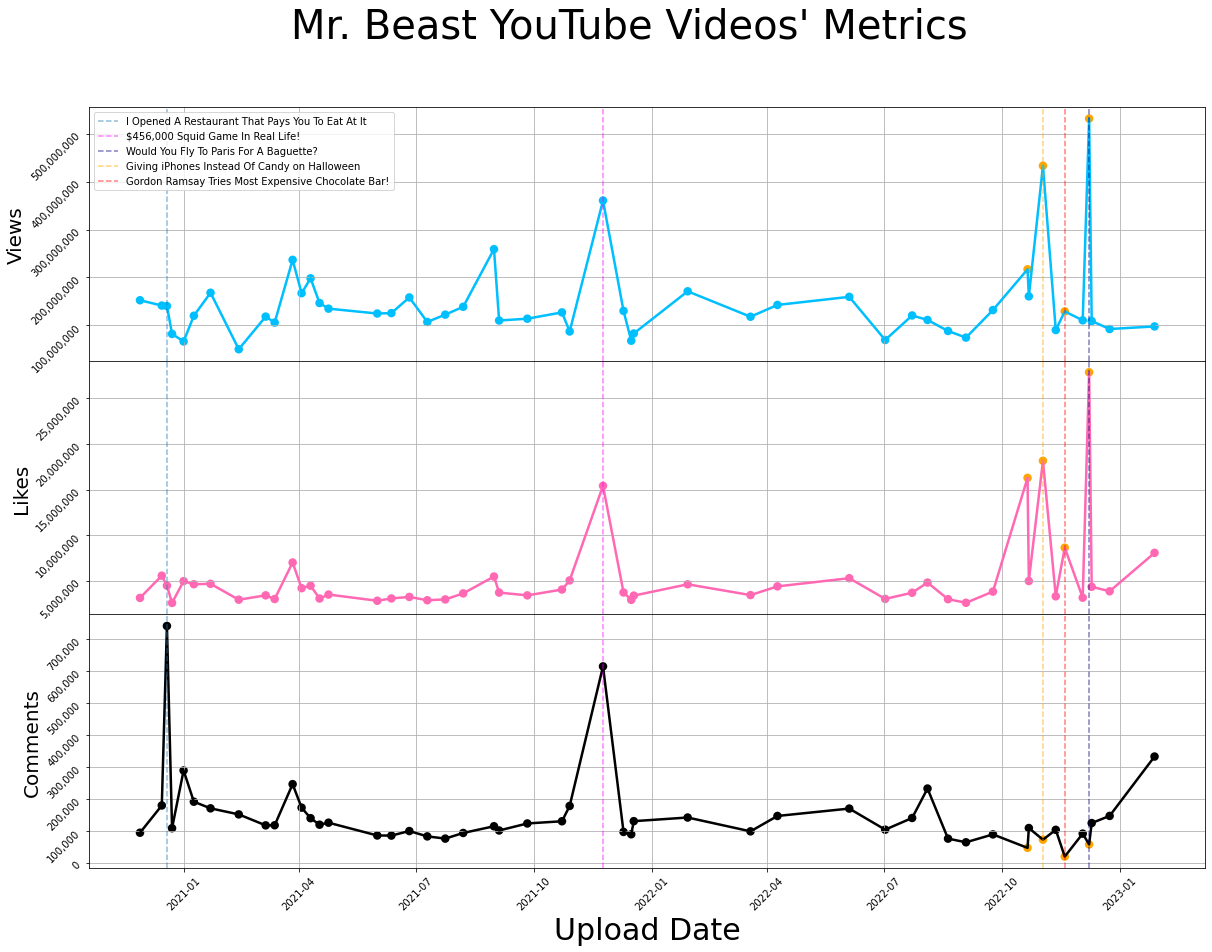

In [14]:
#A bunch of taped-together plotting code to make the data look nice.
#Tableau is a much better software for down-to-earth plots such as the one below
views_color = list(df["video or short"].apply(lambda x : "orange" if x == "short" else "deepskyblue"))
likes_color = list(df["video or short"].apply(lambda x : "orange" if x == "short" else "hotpink"))
comments_color = list(df["video or short"].apply(lambda x : "orange" if x == "short" else "black"))

fig, axs = plt.subplots(nrows = 3, figsize = (20,14), sharex=True)


axs[0].plot(df["datetime"], df["views"], color = "deepskyblue", lw = 2.5)
axs[0].scatter(df["datetime"], df["views"], color = views_color, lw = 2.5)
axs[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[0].tick_params(labelrotation=45)
axs[0].set_ylabel("Views", fontsize = 20) 

axs[1].plot(df["datetime"], df["likes"], color = "hotpink", lw = 2.5)
axs[1].scatter(df["datetime"], df["likes"], color = likes_color, lw = 2.5)
axs[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[1].tick_params(labelrotation=45)
axs[1].set_ylabel("Likes", fontsize = 20) 

axs[2].plot(df["datetime"], df["comments"], color = "black", lw = 2.5)
axs[2].scatter(df["datetime"], df["comments"], color = comments_color, lw = 2.5)
axs[2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[2].tick_params(labelrotation=45)
axs[2].set_ylabel("Comments", fontsize = 20) 


for i in range(len(axs)):
    axs[i].axvline(x = df.loc[47,"datetime"], label = "I Opened A Restaurant That Pays You To Eat At It", alpha = .5, linestyle = "--")    
    axs[i].axvline(x = df.loc[23, "datetime"], label = '$456,000 Squid Game In Real Life!', color = "fuchsia", linestyle = "--", alpha = .5)    
    axs[i].axvline(x = df.loc[3, "datetime"],  label = "Would You Fly To Paris For A Baguette?", color = "navy", alpha = .5, linestyle = "--")    
    axs[i].axvline(x = df.loc[7, "datetime"],  label = "Giving iPhones Instead Of Candy on Halloween", color = "orange", alpha = .5, linestyle = "--")
    axs[i].axvline(x = df.loc[5, "datetime"],  label = "Gordon Ramsay Tries Most Expensive Chocolate Bar!", color = "red", alpha = .5, linestyle = "--")


axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].legend(loc = "best")

axs[2].set_xlabel("Upload Date", fontsize = 30)

plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("Mr. Beast YouTube Videos' Metrics", fontsize=40)

#Save as png file. For a better view of the plot please look at png file.
plt.savefig("mrbeast.png") 

# Correlations

At first glance we can see that most of the peaks and troughs in each metric lines up with the peaks and troughs of other metrics, but when we check the correlation matrix:

In [15]:
df.corr()

,likes,comments,views
likes,1.000000,0.099634,0.878180
comments,0.099634,1.000000,0.104592
views,0.878180,0.104592,1.000000


We can see that the comments metric is not well-correlated with the other metrics. If we take a closer look at the plots above, we can see that at some peaks of the likes/views data, there is no peak for the comments data. This is most likely due to the shorts being part of this dataset. __It seems as if YouTube shorts comments have a lower correlation with likes/views than YouTube videos.__

To explore this let's look at the correlation matrix with only YouTube videos. We will also remove the video on about December 2020 titled "I Opened A Restaurant That Pays You To Eat At It". I will go in more depth analysis on this video below and why we can remove it from this correlation matrix.

In [16]:
#Not the Mr. Beast Burger video
df[(df["title"] != "I Opened A Restaurant That Pays You To Eat At It") 
   & (df["video or short"] == "video")].corr()

,likes,comments,views
likes,1.000000,0.935859,0.726101
comments,0.935859,1.000000,0.543233
views,0.726101,0.543233,1.000000


Although our views are now less-correlated with likes, this correlation matrix is a more accurate representation of the how well views, likes and comments are correlated for YouTube videos. However, why __are__ views less correlated with comments and likes?
<br>
<br>
My suspicion is that although a video may have a lot of views, not everyone will like/comment, but those who like will also comment and those who comment will also like.
<br>
<br>
Some caution is warranted when looking at correlation here because views are not necessarily one-to-one in terms of viewer. For example, I can watch a specific Mr.Beast video twice (maybe I watch 1 minute of the beginning and I come finish it at a later time), but I can only drop 1 like and I am most likely to only leave one comment if I leave any at all. This will add 2 views to the data, but only 1 like and 0-1 comments. 
<br>
<br>
This variability in the data makes analyzing correlations a bit tricky. If we were able to match a view to a specific user, then we would be able to replace the total views data with unique views data, which would give a more robust measure of correlation.

# Analyzing Peaks in Metrics

Let's talk about some of thes vertical lines, representing peaks in video metric(s).
<br>
<br>

1) __I Opened A Restaurant That Pays You To Eat At It__

This video is interesting because the view and like counts are low compared to a lot of other videos, but it has the highest comment count of any Mr. Beast video. But why? This video marks the debut of Mr. Beast Burger, a chain of cloud kitchen restaurants with burger favorites from the Mr. Beast team. In the final minute of the video Mr. Beast apologizes to his international audience for not being able to open up Mr. Beast Burgers to an international audience, and to make up for it he'll give away 10,000 dollars to an international viewer. 
I saw a plethora of comments written in different languages. This implies that the main reason why this video has so many more comments than the others is because a large international audience left a comment in an attempt to win 10,000 dollars. With this in mind, we were able to remove this video from our correlation matrix because it is anomolous and we know why.
<br>
<br>

2) __456,000 Squid Game In Real Life!__

Mr. Beasts' adaptation of Squid Game was a ridiculously cool video, featuring a version of each of the games played in the Squid Game Netflix show. The Netflix show had a huge audience, so it makes sense that those who watched the show would be interested in this grand adaptation of the show.
<br>
<br>

3) __Giving iPhones Instead Of Candy on Halloween__

This is a YouTube short. Some shorts are heavily promoted on YouTube and it's even shorter than Mr. Beast's usual videos by being about a minute long. This accessability and short duration are a great combination to ensure high viewership. However, why are the comments so low? Most people watch shorts on their phone and perhaps they comment less on this type of media compared to lengthy YouTube videos. My assumption is that you are more likely to have an opinion/ comment on media the longer you are viewing it and/or viweres are more comfortable typing comments on their computer than on their phone. Since (I'm assuming) most people watch shorts on their phone and videos on a computer.
<br>
<br>

4) __Would You Fly To Paris For A Baguette?__
This video has the highest amount of views in this dataset. It is also a YouTube short and features Mr. Beast offering everyday people the opportunity for a free trip to Paris as long as they just come back with some baguettes. The video features grand clips from the trips to Paris including shots with the Mona Lisa and Eiffel Tower.
<br>
<br>

5) __Gordon Ramsay Tries Most Expensive Chocolate Bar!__
This video has relatively low views/likes compared to the other shorts, but upon looking in the comments section Mr. Beast announced his apologies for having to reupload the short. This means that the views/likes/comments all reset and all these statistics would have been higher otherwise.

# Future Explorations
<br>

So far, there is not much data involving YouTube shorts and this small sample size is not large enough to draw any concrete conclusions or business insights, in my opinion.

However, if I were to draw insights from these 4 shorts, I would say that creating shorts where Mr. Beast is giving away to regular people as opposed to having celebrities in his shorts would make  content with more consistent views/likes.